# Exploring Scotch Whiskies

This assignment is based on a paper that appeared in 1996, [Pierre Legendre](http://numericalecology.com/) and [F.-J. Lapointe](http://bio.umontreal.ca/repertoire-departement/vue/lapointe-francois-joseph/) performed a classification of pure malt whiskeys. We will go through their findings and explore their data using Machine Learning techniques.


---

> Christos Kallaras , p2822009 <br />
>Department of Management Science and Technology <br />
>Master in Business Analytics <br />
>Athens University of Economics and Business


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import scipy.stats.stats as stats
from plotnine import *
import requests
from zipfile import ZipFile
from io import BytesIO
import sklearn as sk
import seaborn as sns

%matplotlib inline

Before going to the questions i need to load the necesssary file.

In [2]:
#Read the file
#First fetch the file, then load it using the ZipFile module. I do this because there are multiple
#files inside that zip file.
r = requests.get('http://adn.biol.umontreal.ca/~numericalecology/labo/Scotch/ScotchData.zip')
files = ZipFile(BytesIO(r.content))
scotch = pd.read_excel(files.open('ScotchData/Scotch data (Windows)/scotch.xlsx'),header=[0,1])

print(scotch.shape)
scotch.head(5)


(111, 85)


C:\Users\Christos Kallaras\Anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
C:\Users\Christos Kallaras\Anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:300: UserWarning: Unknown extension is not supported and will be removed


Unnamed: 0_level_0 Unnamed: 1_level_0 color                                 \
                NAME               NAME  wyne yellow v.pale pale p.gold gold   
0          Aberfeldy          Aberfeldy   0.0    1.0    0.0  0.0    0.0  0.0   
1           Aberlour           Aberlour   0.0    0.0    0.0  0.0    0.0  0.0   
2            Ardberg            Ardberg   0.0    0.0    0.0  0.0    0.0  0.0   
3            Ardmore            Ardmore   0.0    0.0    0.0  0.0    1.0  0.0   
4       Auchentoshan         Auchentosh   0.0    0.0    0.0  0.0    1.0  0.0   

                 ...      FIN                                              \
  o.gold f.gold  ... DISTRICT islay midland spey east west north  lowland   
0    0.0    0.0  ...  MIDLAND   0.0     1.0  0.0  0.0  0.0    0.0     0.0   
1    0.0    0.0  ...     SPEY   0.0     0.0  1.0  0.0  0.0    0.0     0.0   
2    0.0    0.0  ...    SOUTH   1.0     0.0  0.0  0.0  0.0    0.0     0.0   
3    0.0    0.0  ...     SPEY   0.0     0.0  1.0  0.0  0.0    0.0     0.0   
4    0.0    0.0  ...     WEST   0.0     0.0  0.0  0.0  0.0    0.0     1.0   

                    
  campbell islands  
0      0.0     0.0  
1      0.0     0.0  
2      0.0     0.0  
3      0.0     0.0  
4      0.0     0.0  

[5 rows x 85 columns]

### Q1 Score Prediction

In this question i will find a model to predict the score of schotch a whiskey based on the attributes collected by the authors. 

First i need to deal with the headers.

In [3]:
for col in scotch.columns:
    print (col)

('Unnamed: 0_level_0', 'NAME')
('Unnamed: 1_level_0', 'NAME')
('color', 'wyne')
('color', 'yellow')
('color', 'v.pale')
('color', 'pale')
('color', 'p.gold')
('color', 'gold')
('color', 'o.gold')
('color', 'f.gold')
('color', 'bronze')
('color', 'p.amber')
('color', 'amber')
('color', 'f.amber')
('color', 'red')
('color', 'sherry')
('NOSE', 'AROMA')
('NOSE', 'PEAT')
('NOSE', 'SWEET')
('NOSE', 'LIGHT')
('NOSE', 'FRESH')
('NOSE', 'DRY')
('NOSE', 'FRUIT')
('NOSE', 'GRASS')
('NOSE', 'SEA')
('NOSE', 'SHERRY')
('NOSE', 'SPICY')
('NOSE', 'RICH')
('BODY', 'soft')
('BODY', 'med')
('BODY', 'full')
('BODY', 'round')
('BODY', 'smooth')
('BODY', 'light')
('BODY', 'firm')
('BODY', 'oily')
('PAL', 'full')
('PAL', 'dry')
('PAL', 'sherry')
('PAL', 'big')
('PAL', 'light')
('PAL', 'smooth')
('PAL', 'clean')
('PAL', 'fruit')
('PAL', 'grass')
('PAL', 'smoke')
('PAL', 'sweet')
('PAL', 'spice')
('PAL', 'oil')
('PAL', 'salt')
('PAL', 'arome')
('FIN', 'full')
('FIN', 'dry')
('FIN', 'warm')
('FIN', 'big')
('FIN

We can see that there is a multilevel header structure so i drop the levels and keep only the last which shows the necessary information.

In [4]:
scotch.columns = scotch.columns.droplevel()
scotch.head(5)

,NAME,NAME,wyne,yellow,v.pale,pale,p.gold,gold,o.gold,f.gold,...,DISTRICT,islay,midland,spey,east,west,north,lowland,campbell,islands
0,Aberfeldy,Aberfeldy,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,MIDLAND,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Aberlour,Aberlour,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,SPEY,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Ardberg,Ardberg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,SOUTH,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Ardmore,Ardmore,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,SPEY,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Auchentoshan,Auchentosh,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,WEST,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


We can see that there are null values. This is beacuse there is an extra line in the dataset right before the summarizing line as we can see bellow.

In [5]:
scotch.tail(5)

,NAME,NAME,wyne,yellow,v.pale,pale,p.gold,gold,o.gold,f.gold,...,DISTRICT,islay,midland,spey,east,west,north,lowland,campbell,islands
106,Tomintoul,Tomintoul,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,SPEY,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
107,Tormore,Tormore,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,SPEY,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
108,Tullibardine,Tullibardi,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,MIDLAND,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110,NaN,NaN,8.0,2.0,2.0,4.0,10.0,21.0,2.0,27.0,...,NaN,7.0,6.0,57.0,10.0,5.0,7.0,9.0,3.0,5.0


We dont need that line and we also do not need the summarizing results, so i will remove them.

In [6]:
#remove the final 2 rows; the null row and the summary
scotch = scotch[:-2]
scotch.tail(5)

,NAME,NAME,wyne,yellow,v.pale,pale,p.gold,gold,o.gold,f.gold,...,DISTRICT,islay,midland,spey,east,west,north,lowland,campbell,islands
104,Tobermory,Tobermory,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,MULL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
105,Tomatin,Tomatin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,SPEY,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
106,Tomintoul,Tomintoul,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,SPEY,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
107,Tormore,Tormore,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,SPEY,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
108,Tullibardine,Tullibardi,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,MIDLAND,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Column NAME is duplicated so i will delete one of them by keeping the name information in an array (which i will then filter to keep only one occurance of each name) and then add it back to the dataset. 

In [7]:
names = np.array(scotch['NAME'])
names = [item[0] for item in names]
names

['Aberfeldy',
 'Aberlour',
 'Ardberg',
 'Ardmore',
 'Auchentoshan',
 'Aultmore',
 'Balblair',
 'Balmenach',
 'Balvenie',
 'Banff',
 'Ben Nevis',
 'Benriach',
 'Benrinnes',
 'Benromach',
 'Bladnoch',
 'Blair Athol',
 'Bowmore',
 'Brackla',
 'Bruichladdich',
 'Bunnahabhain',
 'Caol Ila',
 'Caperdonich',
 'Cardhu',
 'Clynelish',
 'Coleburn',
 'Convalmore',
 'Cragganmore',
 'Craigellachie',
 'Dailuaine',
 'Dallas Dhu',
 'Dalmore',
 'Dalwhinnie',
 'Deanston',
 'Dufftown',
 'Edradour',
 'Fettercairn',
 'Glen  Albyn',
 'Glenallachie',
 'Glenburgie',
 'Glencadam',
 'Glen Deveron',
 'Glendronach',
 'Glendullan',
 'Glen Elgin',
 'Glenesk',
 'Glenfarclas',
 'Glenfiddich',
 'Glen Garioch',
 'Glenglassaugh',
 'Glengoyne',
 'Glen Grant',
 'Glen Keith',
 'Glenkinchie',
 'Glenlivet',
 'Glenlochy',
 'Glenlossie',
 'Glen Mhor',
 'Glenmorangie',
 'Glen Moray',
 'Glen Ordie',
 'Glenrothes',
 'Glen Scotia',
 'Glen Spey',
 'Glentauchers',
 'Glenturret',
 'Glenugie',
 'Glenury Royal',
 'Highland Park',
 'Imp

I need to apply Label Encoding to the categorical values. Region and district seem to be values indicating categories. We can verify it by finding their unique values.


In [8]:
scotch['REGION'].unique()

array(['HIGH', 'ISLAY', 'LOW', 'LOW '], dtype=object)

In [9]:
scotch['DISTRICT'].unique()

array(['MIDLAND', 'SPEY', 'SOUTH', 'WEST', 'NORTH', 'BORDERS', 'LOCH',
       'EAST', 'CAMPBEL', 'ORKNEY', 'JURA', 'NORTHWEST', 'CENTRAL',
       'SKYE', 'MULL'], dtype=object)

In order to transform them into numerical i will transform them into category.


In [10]:
scotch['REGION'] = scotch['REGION'].astype('category')
scotch['DISTRICT'] = scotch['DISTRICT'].astype('category')
scotch.head(5)

,NAME,NAME,wyne,yellow,v.pale,pale,p.gold,gold,o.gold,f.gold,...,DISTRICT,islay,midland,spey,east,west,north,lowland,campbell,islands
0,Aberfeldy,Aberfeldy,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,MIDLAND,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Aberlour,Aberlour,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,SPEY,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Ardberg,Ardberg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,SOUTH,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Ardmore,Ardmore,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,SPEY,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Auchentoshan,Auchentosh,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,WEST,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Now i can apply Label Encoding and transform them into numerical.

In [11]:
scotch['REGION'] = scotch['REGION'].cat.codes
scotch['DISTRICT'] = scotch['DISTRICT'].cat.codes
scotch.head(5)

,NAME,NAME,wyne,yellow,v.pale,pale,p.gold,gold,o.gold,f.gold,...,DISTRICT,islay,midland,spey,east,west,north,lowland,campbell,islands
0,Aberfeldy,Aberfeldy,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Aberlour,Aberlour,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Ardberg,Ardberg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Ardmore,Ardmore,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,13,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Auchentoshan,Auchentosh,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,14,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


We do not need the column Name so i delete it.

In [12]:
scotch = scotch.drop(columns=["NAME"])
scotch.head(5)

,wyne,yellow,v.pale,pale,p.gold,gold,o.gold,f.gold,bronze,p.amber,...,DISTRICT,islay,midland,spey,east,west,north,lowland,campbell,islands
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,13,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,14,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Now lets take a look at the correlations between the variables.

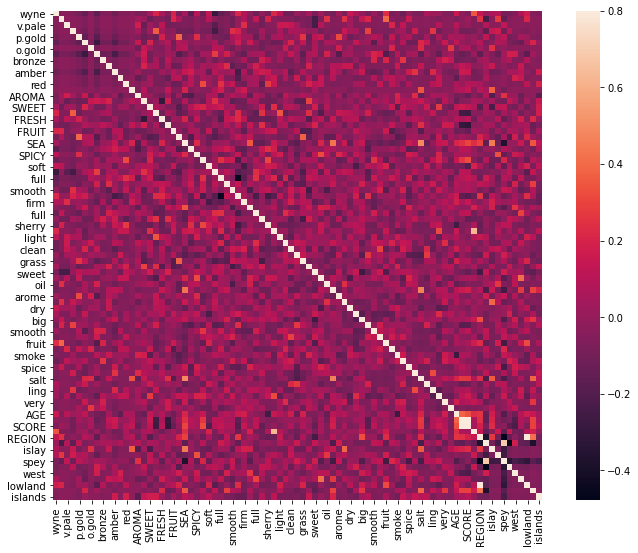

In [13]:
#correlation matrix
corrmat = scotch.corr()
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=.8, square=True);

I will try to build 3 diferent models and evaluate them.

First i will keep the variable we want to predict separately from the rest of the dataset and then i will divide the dataset in to training and test sets.

In [14]:
x = scotch.drop(['SCORE'], axis=1)
y = scotch['SCORE']

x.shape, y.shape

((109, 82), (109,))

I will split the dataset; test data will be 30% of the entire dataset.

In [15]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

x_train.shape, y_train.shape

((76, 82), (76,))

x_train and y_train will be used to train the model, while x_test to test it. y_test holds the actual values.

I will first create a linear regression model.

In [16]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(x_train,y_train)
lr_pred = lr.predict(x_test)

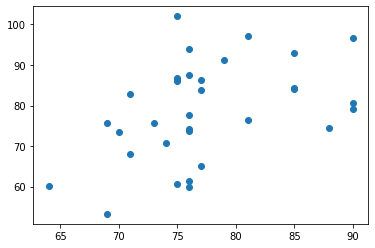

In [17]:
plt.scatter(y_test, lr_pred)

As we can see from the above scatterplot of the predicted values with the actuals, they seem to be completely wrong. In order for the model to be good we must have a scatterplot that resembles a line.

I will then plot the model's residuals, which are the difference between the actual values and the predicted values.

(array([1., 0., 2., 6., 5., 3., 5., 3., 2., 6.]),
 array([-27.01908261, -22.71507459, -18.41106657, -14.10705855,
         -9.80305053,  -5.49904251,  -1.19503449,   3.10897353,
          7.41298155,  11.71698957,  16.02099759]),
 <a list of 10 Patch objects>)

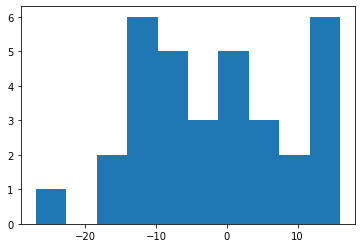

In [18]:
plt.hist(y_test - lr_pred)

To further evaluate the model i will calculate 4 metrics : 

* Mean absolute error (MAE)
* Mean absolute error (MSE)
* Root mean squared error (RMSE)
* R2
    

For this purpose i created a function that calculate those metrics and prints them.

In [19]:
from sklearn import metrics
def evaluate(true,pred):
    mae = metrics.mean_absolute_error(true, pred)
    mse = metrics.mean_squared_error(true, pred)
    rmse = np.sqrt(metrics.mean_squared_error(true, pred))
    r2=metrics.r2_score(true, pred)
    print('MAE : ',mae)
    print('MSE : ',mse)
    print('RMSE : ',rmse)
    print('R2 : ',r2)

In [20]:
evaluate(y_test,lr_pred)

MAE :  9.155082177514146
MSE :  119.36344297129526
RMSE :  10.925357796030996
R2 :  -1.9803913742316812


Overall the linear regression model does not seem to be appropriate for our problem.

Next i will create a K-Nearest Neighbour model. Note that KNN is a classifier algorithm so we do not expect great results althought it can be used for predictions.

In [21]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier()
neigh.fit(x_train, y_train)
knn_pred = neigh.predict(x_test)

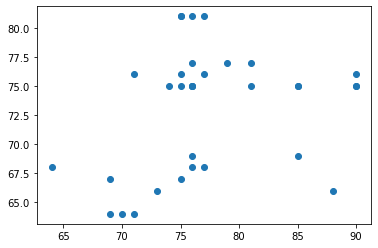

In [22]:
plt.scatter(y_test, knn_pred)

(array([6., 3., 7., 2., 5., 5., 0., 4., 0., 1.]),
 array([-6. , -3.2, -0.4,  2.4,  5.2,  8. , 10.8, 13.6, 16.4, 19.2, 22. ]),
 <a list of 10 Patch objects>)

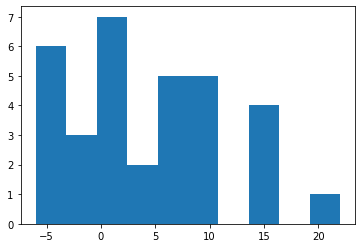

In [23]:
plt.hist(y_test - knn_pred)

The scatter plot resembles a straight line, meaning that some of our predictions were true while the residuals are not normally distributed.

In [24]:
evaluate(y_test,knn_pred)

MAE :  6.363636363636363
MSE :  67.39393939393939
RMSE :  8.209381182156143
R2 :  -0.6827624157380658


The results seem to be better than the ones from linear regression model. R2 is positive while all the rest values are closer to 0 with the escpetion of MSE.

The final model will be a Decision Trees model.

In [25]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=0)
dt.fit(x_train, y_train)
dt_pred = dt.predict(x_test)

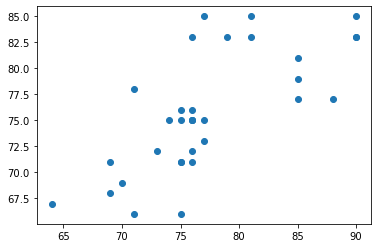

In [26]:
plt.scatter(y_test, dt_pred)

(array([3., 0., 3., 4., 8., 1., 8., 3., 2., 1.]),
 array([-8. , -6.1, -4.2, -2.3, -0.4,  1.5,  3.4,  5.3,  7.2,  9.1, 11. ]),
 <a list of 10 Patch objects>)

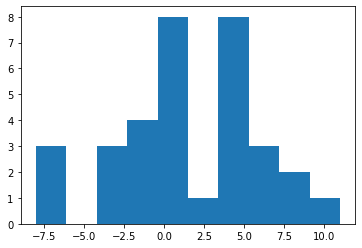

In [27]:
plt.hist(y_test - dt_pred)

In [28]:
evaluate(y_test,dt_pred)

MAE :  3.9393939393939394
MSE :  23.575757575757574
RMSE :  4.85548736747997
R2 :  0.4113358096024212


The scatter plot is closer to a straight line meaning that our predictions are close to the actual values.
The metrics are also much better than the previous, and are close to 0. The errors are close to zero; an other indicator that the predicted values are close to the actuals.R2 is 0.41 which indicates good fit of the data to the model. The histogram of the residuals does not resembles the normal distribution. It is worth noting that we get much better results if we remove REGION and DISTRICT. Specifically the errors were closer to 0 and R2 was at 0.92%.

Overall Decision trees seems to be the best model for out dataset with a good fit of the data and the smallest error.

### Q2 PCA

In this question i will perform a PCA analysis on the data to reduce the number of dimensions.

PCA is affected by feature scales, but the dataset consists of mainly dummy binary variables so there is no point in transforming them.The variance also does not varies a lot.

In [30]:
scotch.describe()

,wyne,yellow,v.pale,pale,p.gold,gold,o.gold,f.gold,bronze,p.amber,...,DISTRICT,islay,midland,spey,east,west,north,lowland,campbell,islands
count,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,...,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000
mean,0.073394,0.018349,0.018349,0.036697,0.091743,0.192661,0.018349,0.247706,0.045872,0.036697,...,10.284404,0.064220,0.055046,0.522936,0.091743,0.045872,0.064220,0.082569,0.027523,0.045872
std,0.261987,0.134829,0.134829,0.188886,0.289996,0.396210,0.134829,0.433674,0.210173,0.188886,...,4.143473,0.246277,0.229123,0.501781,0.289996,0.210173,0.246277,0.276501,0.164357,0.210173
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,13.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,13.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,14.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


I will now run PCA for two components.

In [31]:
from sklearn.decomposition import PCA

n_components=2

pca_ = PCA(n_components=n_components)
pca_.fit(scotch)
pca_.components_.shape

(2, 83)

In [32]:
print(pca_.explained_variance_ratio_)
print(pca_.explained_variance_ratio_.sum())

[0.59529972 0.22157548]
0.8168752001987565


As we can see the first principal component contains 59% of the variance and the second principal component contains 22% of the variance. Together, the two components contain 81% of the information.

It is worth noting that PCA is desinged for continuous variables. The goal is to try and minimize variance. The concept of squared deviations breaks down when we have binary variables. Nonetheless we can use it. 

### Q3 Clustering without Geographical Information

In this question i will cluster the data, without taking into account the geographical information (regions, districts, geographical coordinates).

First i need to find the optimal number of clusters. I will first use the elbow method.

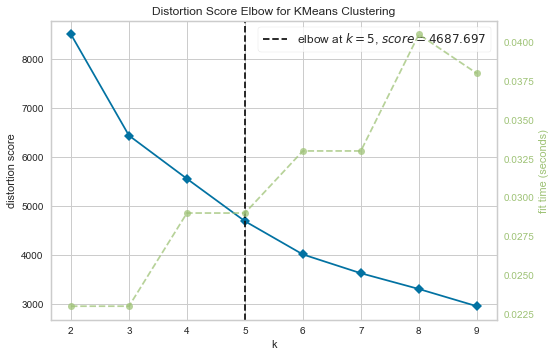

In [33]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

kmeans = KMeans(random_state=0)
visualizer = KElbowVisualizer(kmeans, k=(2,10))

visualizer.fit(scotch)
visualizer.show()

As we can see the optimal number of clusters is 5 for a range of 2 to 10.

Next i will use Silhouette plots and scores.

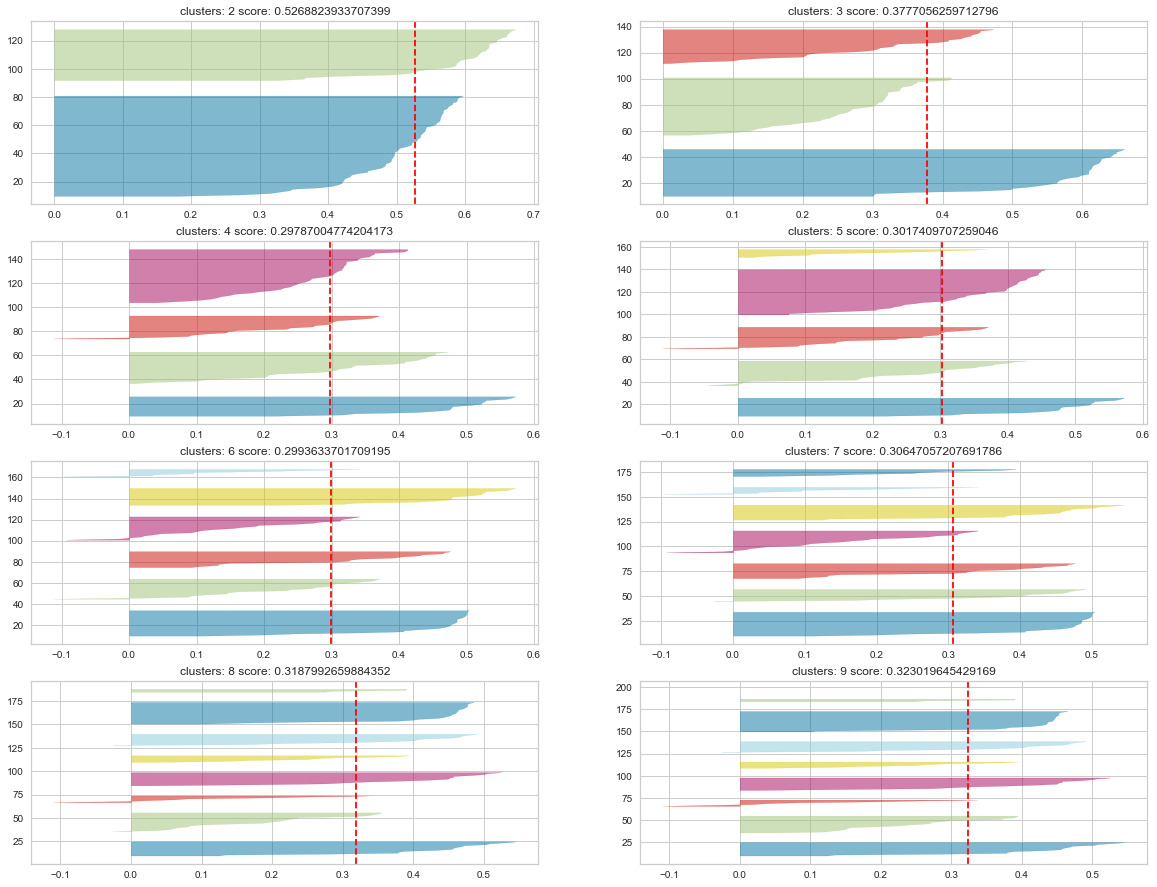

In [34]:
from yellowbrick.cluster import SilhouetteVisualizer

plt.figure(figsize=(2 * 10,  10 * 6))

scores = {}
for n_clusters in range(2, 10):
    plt.subplot(15, 2, n_clusters - 1)
    kmeans = KMeans(n_clusters, random_state=42)
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
    visualizer.fit(scotch)
    scores[n_clusters] = visualizer.silhouette_score_
    plt.title(f'clusters: {n_clusters} score: {visualizer.silhouette_score_}')

In [35]:
sorted(scores.items(), key=lambda kv: kv[1], reverse=True)

[(2, 0.5268823933707399),
 (3, 0.3777056259712796),
 (9, 0.323019645429169),
 (8, 0.3187992659884352),
 (7, 0.30647057207691786),
 (5, 0.3017409707259046),
 (6, 0.2993633701709195),
 (4, 0.29787004774204173)]

The Silhouette plots as well as the scores indicate that the optimal number of clusters is 2. The silhouette score of 2 is better than the one of 5 by far so i will choose 2 .

To have a better understanding and decide the number of clusters i will use Hierarchical complete linkage and plot the dendogram.

In [36]:
from scipy.cluster.hierarchy import dendrogram, linkage

cluster_model_complete = linkage(scotch, 'complete')

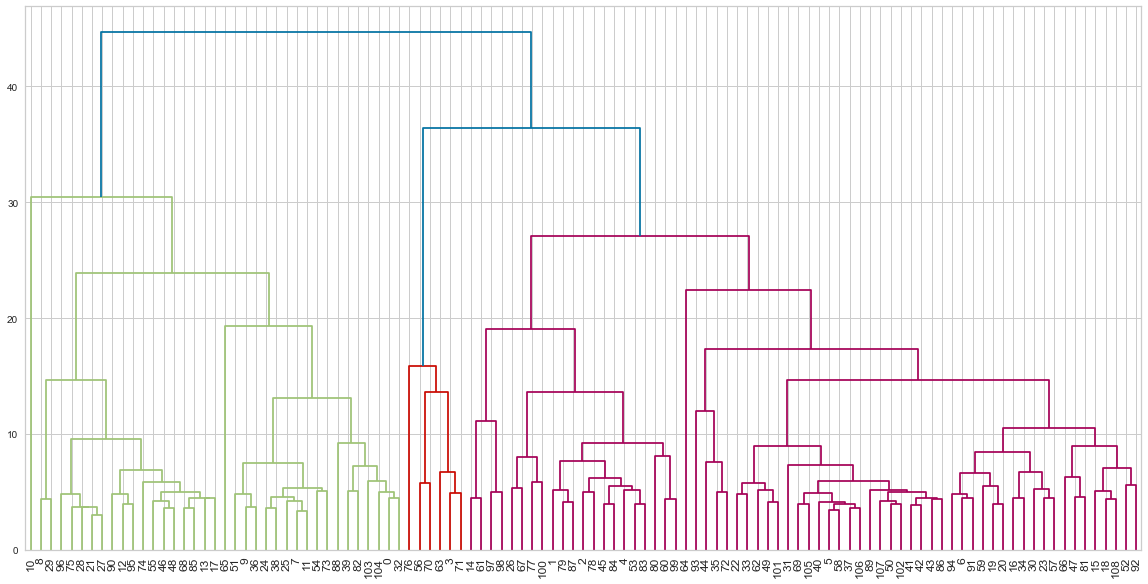

In [37]:
plt.figure(figsize=(20, 10))
_ = dendrogram(cluster_model_complete, orientation='top', leaf_font_size=12)

Based on all of the above i will continue with 2 clusters which i will extract using the fcluster() function.

In [38]:
from scipy.cluster.hierarchy import fcluster

hc_labels = fcluster(cluster_model_complete, 2, criterion='maxclust')
hc_labels

array([1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1,
       2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2,
       2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2,
       1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2],
      dtype=int32)

I will now assign each cluster to the corresponding row while also add the names again in the dataset.

In [39]:
scotch['Cluster'] = hc_labels
scotch['NAME'] = names
scotch.head(5)

,wyne,yellow,v.pale,pale,p.gold,gold,o.gold,f.gold,bronze,p.amber,...,midland,spey,east,west,north,lowland,campbell,islands,Cluster,NAME
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,Aberfeldy
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,Aberlour
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,Ardberg
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,Ardmore
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,Auchentoshan


I will then group by the clusters and get the sums of all the variables.This will help me understand the diferences between clusters.

In [40]:
only_dummies = scotch.groupby(by=['Cluster']).sum()
only_dummies

,wyne,yellow,v.pale,pale,p.gold,gold,o.gold,f.gold,bronze,p.amber,...,DISTRICT,islay,midland,spey,east,west,north,lowland,campbell,islands
Cluster,,,,,,,,,,,,,,,,,,,,,
1,1.0,1.0,0.0,1.0,3.0,5.0,1.0,11.0,3.0,1.0,...,418.0,0.0,2.0,25.0,4.0,3.0,1.0,1.0,0.0,1.0
2,7.0,1.0,2.0,3.0,7.0,16.0,1.0,16.0,2.0,3.0,...,703.0,7.0,4.0,32.0,6.0,2.0,6.0,8.0,3.0,4.0


In this dataset i only need the dummie variables.

In [41]:
#delete columns with Names, Districts and REGION
only_dummies = only_dummies.drop(columns=["SCORE","AGE","%","DIST","REGION","DISTRICT"])
only_dummies

,wyne,yellow,v.pale,pale,p.gold,gold,o.gold,f.gold,bronze,p.amber,...,quick,islay,midland,spey,east,west,north,lowland,campbell,islands
Cluster,,,,,,,,,,,,,,,,,,,,,
1,1.0,1.0,0.0,1.0,3.0,5.0,1.0,11.0,3.0,1.0,...,3.0,0.0,2.0,25.0,4.0,3.0,1.0,1.0,0.0,1.0
2,7.0,1.0,2.0,3.0,7.0,16.0,1.0,16.0,2.0,3.0,...,3.0,7.0,4.0,32.0,6.0,2.0,6.0,8.0,3.0,4.0


To better visualize them we can add as a column to the new transformed dataset the clusters, since they are already grouped and ordered by them.

In [42]:
clusters_ = np.array([1, 2])
only_dummies['Clusters'] = clusters_.tolist()
only_dummies

<ipython-input-42-8238ae32c27f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,wyne,yellow,v.pale,pale,p.gold,gold,o.gold,f.gold,bronze,p.amber,...,islay,midland,spey,east,west,north,lowland,campbell,islands,Clusters
Cluster,,,,,,,,,,,,,,,,,,,,,
1,1.0,1.0,0.0,1.0,3.0,5.0,1.0,11.0,3.0,1.0,...,0.0,2.0,25.0,4.0,3.0,1.0,1.0,0.0,1.0,1
2,7.0,1.0,2.0,3.0,7.0,16.0,1.0,16.0,2.0,3.0,...,7.0,4.0,32.0,6.0,2.0,6.0,8.0,3.0,4.0,2


Next i will plot the attributes with their clusters.

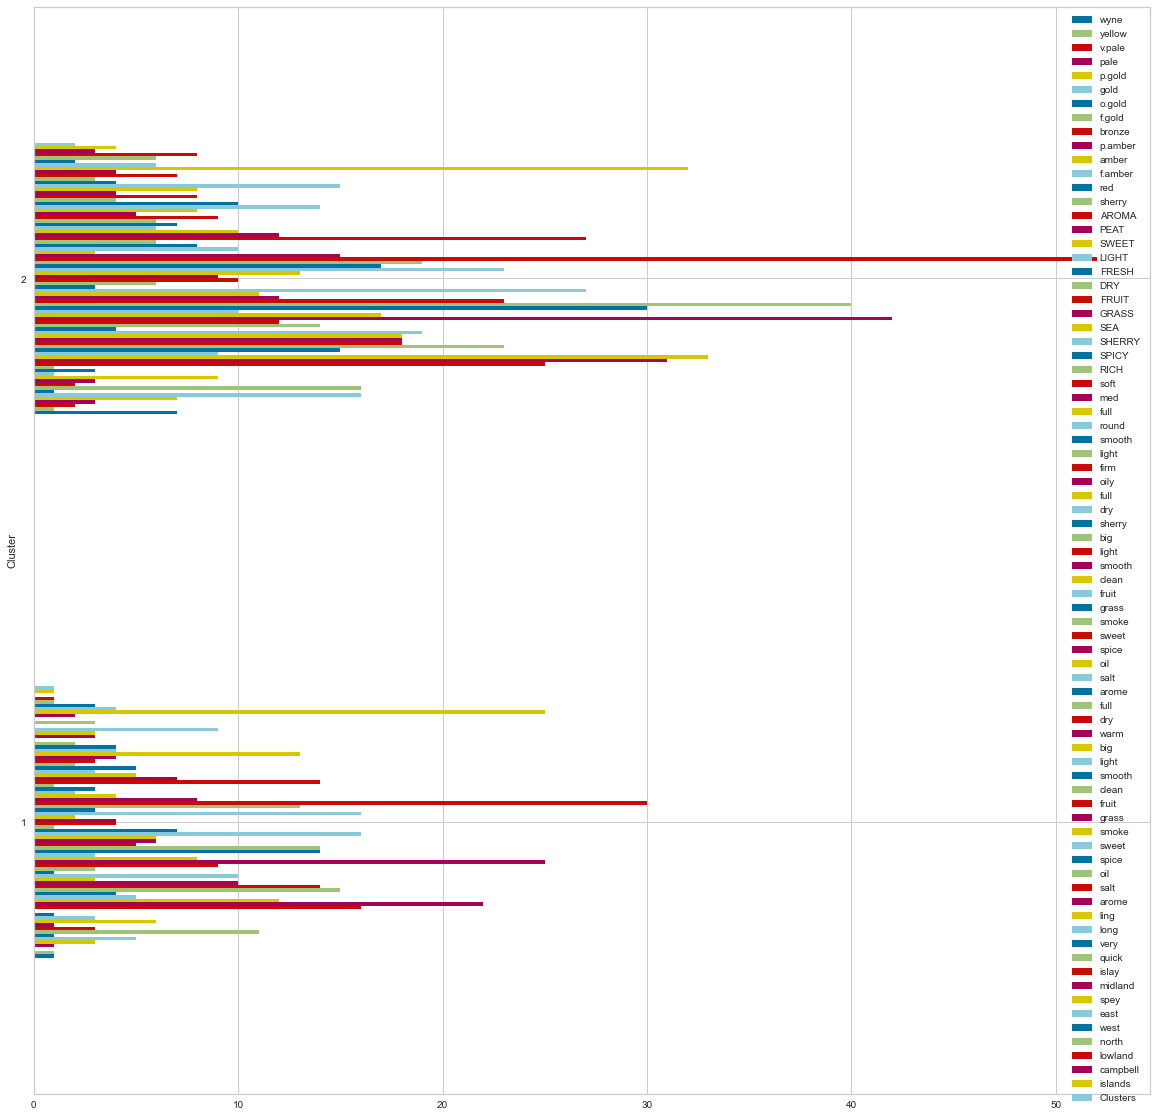

In [43]:
only_dummies.plot(kind='barh',figsize=(20, 20))

Next i will find the whiskies on each group.

In [44]:
clusters = scotch.pivot_table(index='NAME',
                                 columns='Cluster',
                                 values='SCORE',
                                 aggfunc='max')

In [45]:
clusters.sort_values(by=[1],ascending=False).head(40)

Cluster,1,2
NAME,,
Balvenie,85.0,NaN
Dallas Dhu,85.0,NaN
Port Ellen,79.0,NaN
Singleton,79.0,NaN
Benrinnes,78.0,NaN
Brackla,77.0,NaN
Glenlossie,76.0,NaN
Millburn,76.0,NaN
Knockando,76.0,NaN


Above we can see the Whiskies for cluster 1. The whiskie with the highest score is Balverie with 85.

In [46]:
clusters.sort_values(by=[2],ascending=False).head(60)

Cluster,1,2
NAME,,
Talisker,NaN,90.0
Springbank-Longrow,NaN,90.0
Cragganmore,NaN,90.0
Highland Park,NaN,90.0
Lagavulin,NaN,89.0
Springbank,NaN,88.0
Macallan,NaN,87.0
Glenfarclas,NaN,86.0
Laphroaig,NaN,86.0


Above we can see the Whiskies for cluster 2. The whiskey with the highest score is Talisker with 90.

We can see that whiskies with highest score are on cluster 2  while on 1 the score are mediocre. Cluster 2 also has more whiskies, specifically 71 while 1 has 38. Cluster 1 also has the smallest scores.

### Q4 Clustering with Geographical Information

In this question i will cluster the distilleries on the geographical coordinates and then check if the clusters i found in Q3 are related to the clusters produced based on the geographical coordinates.

First i need to read the file contnaing the coordinates. The first 6 lines of the txt file are information about the file so i do not need them.

In [47]:
#Read the file
#First fetch the file, then load it using the ZipFile module. I do this because there are multiple
#files inside that zip file.
r = requests.get('http://adn.biol.umontreal.ca/~numericalecology/labo/Scotch/ScotchData.zip')
files = ZipFile(BytesIO(r.content))
coor = pd.read_csv(files.open('ScotchData/Scotch data (Windows)/DISTCOOR.TXT'),skiprows=6,names=['INFO'])

print(coor.shape)
coor.head(5)

(109, 1)


,INFO
0,Aberfeldy 3.875 56.62
1,Aberlour 3.22 57.46
2,Ardberg 6.08 55.64
3,Ardmore 2.67 57.32
4,Auchentoshan 4.39 55.91


I notice that the data are not in a usefull form as there are all in one column. So i will split the colum based on spaces.

In [48]:
coor[['INFO','COORDINATES']] = coor["INFO"].str.split(" ", 1, expand=True)
coor.head(15)

,INFO,COORDINATES
0,Aberfeldy,3.875 56.62
1,Aberlour,3.22 57.46
2,Ardberg,6.08 55.64
3,Ardmore,2.67 57.32
4,Auchentoshan,4.39 55.91
5,Aultmore,3.01 57.60
6,Balblair,4.17 57.83
7,Balmenach,3.13 57.42
8,Balvenie,3.10 57.45
9,Banff,2.51 57.65


As we can see there are values with 2 strings in their name, so i further split them into a new column.

In [49]:
coor[['Second name','COORDINATES']] = coor["COORDINATES"].str.split(" ", 1, expand=True)
coor.head(40)

,INFO,COORDINATES,Second name
0,Aberfeldy,3.875 56.62,
1,Aberlour,3.22 57.46,
2,Ardberg,6.08 55.64,
3,Ardmore,2.67 57.32,
4,Auchentoshan,4.39 55.91,
5,Aultmore,3.01 57.60,
6,Balblair,4.17 57.83,
7,Balmenach,3.13 57.42,
8,Balvenie,3.10 57.45,
9,Banff,2.51 57.65,


Now i need to check if there are names with more than 2 strings. For that i will split the column coordinates again based on spaces.

In [50]:
coor[['Third name','COORDINATES']] = coor["COORDINATES"].str.split(" ", 1, expand=True)
coor.head(40)

,INFO,COORDINATES,Second name,Third name
0,Aberfeldy,3.875 56.62,,
1,Aberlour,3.22 57.46,,
2,Ardberg,6.08 55.64,,
3,Ardmore,2.67 57.32,,
4,Auchentoshan,4.39 55.91,,
5,Aultmore,3.01 57.60,,
6,Balblair,4.17 57.83,,
7,Balmenach,3.13 57.42,,
8,Balvenie,3.10 57.45,,
9,Banff,2.51 57.65,,


I then proceed to merge the columns NAME, Second Name and Thrid Name in order to have the name in one column while also drop the Second Name,Third Name and NAME column.

In [51]:
coor['NAME'] = coor['INFO'] + ' ' + coor['Second name'] + ' ' + coor['Third name']
coor = coor.drop(columns=["Second name","INFO","Third name"])
coor.head(5)

,COORDINATES,NAME
0,3.875 56.62,Aberfeldy
1,3.22 57.46,Aberlour
2,6.08 55.64,Ardberg
3,2.67 57.32,Ardmore
4,4.39 55.91,Auchentoshan


The coordinates are in one column so i split that column into two, the first holding the latitude west information and the second the longitude north.

In [52]:
coor_split = coor.COORDINATES.str.split(" +",expand = True)
coor_split.head(20)

,0,1,2
0,,3.875,56.62
1,,3.22,57.46
2,,6.08,55.64
3,,2.67,57.32
4,,4.39,55.91
5,,3.01,57.60
6,,4.17,57.83
7,,3.13,57.42
8,,3.10,57.45
9,,2.51,57.65


We can see that there are 3 columns meaning that some values are in column 0 as a result of our whitespace elimination. To deal with this i will update column 2 with the value of column 1 if column 2 is None, and then column 1 with the value of column 0.

In [53]:
def fix(row): #row is the value of row. 
    if row[2]==None:
        temp = row[0]
        row[2]=row[1]
        row[1]=temp
    return row
coor_split=coor_split.apply(fix,axis=1)
coor_split.head(20)

,0,1,2
0,,3.875,56.62
1,,3.22,57.46
2,,6.08,55.64
3,,2.67,57.32
4,,4.39,55.91
5,,3.01,57.60
6,,4.17,57.83
7,,3.13,57.42
8,,3.10,57.45
9,,2.51,57.65


For example line 18 had value 6.36 to column 0 and 55.77 to column 1. Column 2 was None meaning that the delimination has failed, so with the function fix that i created ,column 2 will now have value 55.7 and column 1 value 6.36. I can then delete column 0.

In [54]:
coor_split = coor_split.drop(columns=[0])

I add this information to the dataset and delete the column COORDINATES since it no more add anything.

In [55]:
coor['Lat West'] = coor_split[1]
coor['Long North'] = coor_split[2]
coor = coor.drop(columns=["COORDINATES"])
coor.head(5)

,NAME,Lat West,Long North
0,Aberfeldy,3.875,56.62
1,Aberlour,3.22,57.46
2,Ardberg,6.08,55.64
3,Ardmore,2.67,57.32
4,Auchentoshan,4.39,55.91


The final form of this dataset is the one above , containing the names and the coordinates of the distilleries. I also check to see if we have any null values. Since we do not , all the information have been readed succesfully.

In [56]:
#check for null values in all columns
coor.columns[coor.isna().any()].tolist()

[]

One final check is to see if the names were readed and altered correctly is to see if they corresponds to those of the scotch dataset.

In [57]:
coor['NAME'] = coor['NAME'].str.strip()

In [58]:
i=0
for (columnName, columnData) in coor.iteritems():
    for j in columnData.values:
        if columnName == 'NAME' and j != names[i]:
                print('Problematic Name : ',j) 
        i = i+1

Problematic Name :  Saint Magdalene 3.61
Problematic Name :  Springbank-Longrow  5.60


We have 2 values that have not been properly updated, meaning there was an issue from the concatenation. For those 2 we can update their values manualy.

In [59]:
def fix2(row): #row is the value of row. 
    if row['NAME']=='Saint Magdalene 3.61':
        row['NAME']='Saint Magdalene'
        row['Lat West'] = '3.61'
        row['Long North'] = '55.97'
    elif row['NAME']=='Springbank-Longrow  5.60':
        row['NAME']='Springbank-Longrow'
        row['Lat West'] = '5.60'
        row['Long North'] = '55.41'
    return row
coor=coor.apply(fix2,axis=1)
coor.tail(25)

,NAME,Lat West,Long North
84,Macallan,3.21,57.50
85,Millburn,4.14,57.43
86,Miltonduff,3.37,57.66
87,Mortlach,3.11,57.44
88,North Port,2.47,56.71
89,Oban,5.47,56.77
90,Port Ellen,6.18,55.63
91,Pulteney,3.11,58.43
92,Rosebank,3.80,56.00
93,Saint Magdalene,3.61,55.97


In order to keep only the geographical informations of the dataset i will delete the unnecessary columns from the original dataset and then merge it with the file with the coordinates.

In [60]:
scotch1 = scotch[['NAME','REGION','DISTRICT']]
scotch1.head(5)

,NAME,REGION,DISTRICT
0,Aberfeldy,0,6
1,Aberlour,0,13
2,Ardberg,1,12
3,Ardmore,0,13
4,Auchentoshan,2,14


In [61]:
print(scotch1.shape)
print(coor.shape)

(109, 3)
(109, 3)


In [62]:
geo = pd.merge(scotch1,coor,on=None,how='inner')
print(geo.shape)
geo.head(5)

(109, 5)


,NAME,REGION,DISTRICT,Lat West,Long North
0,Aberfeldy,0,6,3.875,56.62
1,Aberlour,0,13,3.22,57.46
2,Ardberg,1,12,6.08,55.64
3,Ardmore,0,13,2.67,57.32
4,Auchentoshan,2,14,4.39,55.91


In [63]:
geo_df = geo.iloc[:, 1:]
geo_df.head(5)

,REGION,DISTRICT,Lat West,Long North
0,0,6,3.875,56.62
1,0,13,3.22,57.46
2,1,12,6.08,55.64
3,0,13,2.67,57.32
4,2,14,4.39,55.91


In [64]:
geo_df.describe()

,REGION,DISTRICT
count,109.000000,109.000000
mean,0.302752,10.284404
std,0.687246,4.143473
min,0.000000,0.000000
25%,0.000000,8.000000
50%,0.000000,13.000000
75%,0.000000,13.000000
max,3.000000,14.000000


The variance varies a lot, so i'll use StandardScaler.

In [66]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(geo_df)
X = scaler.transform(geo_df)
scaled_geo_df = pd.DataFrame(X, index=geo_df.index, columns=geo_df.columns)
scaled_geo_df

,REGION,DISTRICT,Lat West,Long North
0,-0.442564,-1.038789,0.089736,-0.516143
1,-0.442564,0.658419,-0.518112,0.529967
2,1.019239,0.415960,2.136006,-1.736604
3,-0.442564,0.658419,-1.028520,0.355616
4,2.481043,0.900877,0.567663,-1.400355
...,...,...,...,...
104,-0.442564,-0.796331,2.136006,-0.528596
105,-0.442564,0.658419,0.196458,0.368069
106,-0.442564,0.658419,-0.369630,0.268440
107,-0.442564,0.658419,-0.341790,0.430338


In [67]:
scaled_geo_df.describe()

,REGION,DISTRICT,Lat West,Long North
count,1.090000e+02,1.090000e+02,1.090000e+02,1.090000e+02
mean,6.213175e-17,-1.018553e-17,2.643424e-16,1.055934e-14
std,1.004619e+00,1.004619e+00,1.004619e+00,1.004619e+00
min,-4.425645e-01,-2.493538e+00,-1.835891e+00,-2.707992e+00
25%,-4.425645e-01,-5.538724e-01,-6.201938e-01,-5.161427e-01
50%,-4.425645e-01,6.584186e-01,-4.160309e-01,4.926063e-01
75%,-4.425645e-01,6.584186e-01,4.284612e-01,6.295969e-01
max,3.942847e+00,9.008768e-01,2.395849e+00,2.422928e+00


Using the Elbow method i can find the optimal number of clusters.


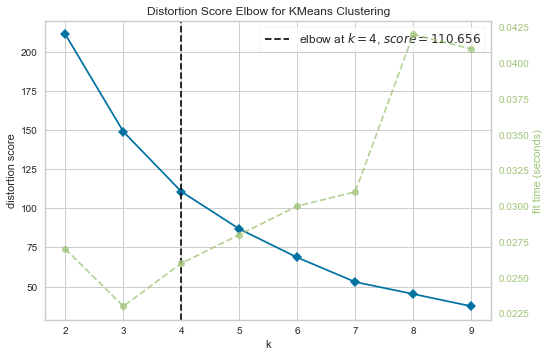

In [68]:

from yellowbrick.cluster import KElbowVisualizer

kmeans = KMeans(random_state=0)
visualizer = KElbowVisualizer(kmeans, k=(2,10))

visualizer.fit(scaled_geo_df)
visualizer.show()

We can see that Elbow methob suggests that 4 is the optimal number of clusters.

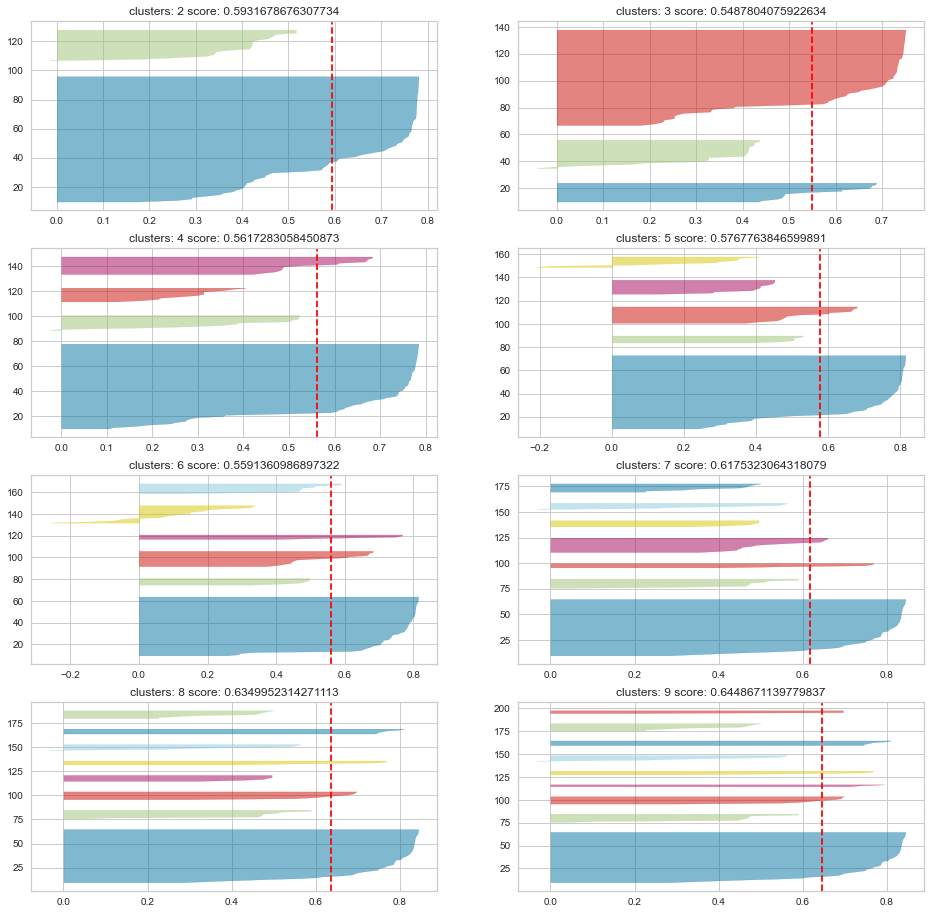

In [69]:
from yellowbrick.cluster import SilhouetteVisualizer

plt.figure(figsize=(4 * 4,  2 * 8))

scores = {}
for n_clusters in range(2, 10):
    plt.subplot(4, 2, n_clusters - 1)
    kmeans = KMeans(n_clusters, random_state=42)
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
    visualizer.fit(scaled_geo_df)
    scores[n_clusters] = visualizer.silhouette_score_
    plt.title(f'clusters: {n_clusters} score: {visualizer.silhouette_score_}')

In [70]:
sorted(scores.items(), key=lambda kv: kv[1], reverse=True)

[(9, 0.6448671139779837),
 (8, 0.6349952314271113),
 (7, 0.6175323064318079),
 (2, 0.5931678676307734),
 (5, 0.5767763846599891),
 (4, 0.5617283058450873),
 (6, 0.5591360986897322),
 (3, 0.5487804075922634)]

Silhouette scores indicates 9 clusters while eldow 4 so i will settle at 7 (which does not have too much distance in terms of silhouete score than 9).

Now let's see number of Regions and Districts.

In [71]:
regions = geo_df['REGION'].value_counts()
print(regions.shape[0])
regions

4


0    89
2    11
1     8
3     1
Name: REGION, dtype: int64

In [72]:
districts = geo_df['DISTRICT'].value_counts()
print(districts.shape[0])
districts

15


13    57
3     10
8      9
14     9
6      6
12     4
1      3
2      2
5      2
10     2
0      1
4      1
7      1
9      1
11     1
Name: DISTRICT, dtype: int64

I will perform PCA in order to visualize the clusters.

In [73]:
from sklearn.decomposition import PCA

pca = PCA()
Y = pca.fit_transform(scaled_geo_df)
print(Y.shape)
pca.explained_variance_ratio_

(109, 4)


array([0.62050643, 0.22110126, 0.11396221, 0.0444301 ])

By ploting the first 3 PC it seems that regions does not cluster together.

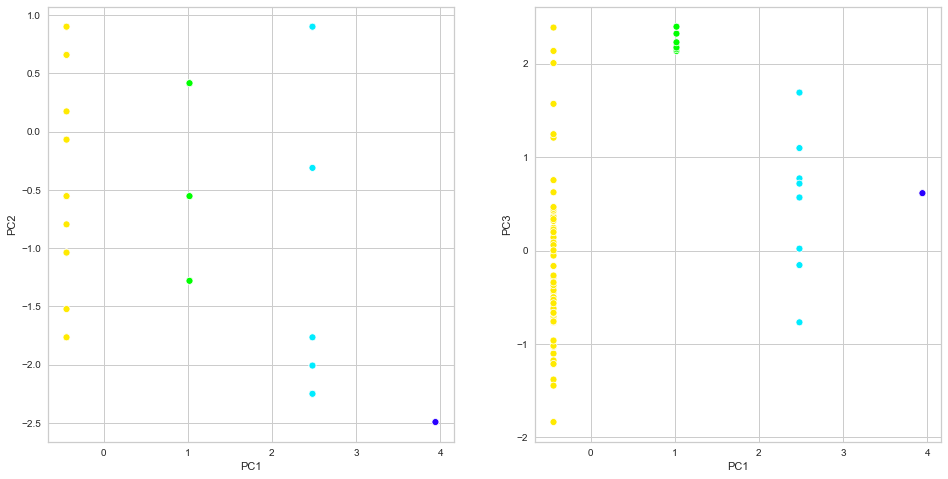

In [74]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=scaled_geo_df['REGION'], 
                palette=sns.color_palette('gist_rainbow', n_colors=regions.shape[0]))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend('')
plt.subplot(1, 2, 2)
sns.scatterplot(x=X[:, 0], y=X[:, 2], hue=geo_df['REGION'], 
                palette=sns.color_palette('gist_rainbow', n_colors=regions.shape[0]))
plt.xlabel('PC1')
plt.ylabel('PC3')

plt.legend('')

The same goes for districts.

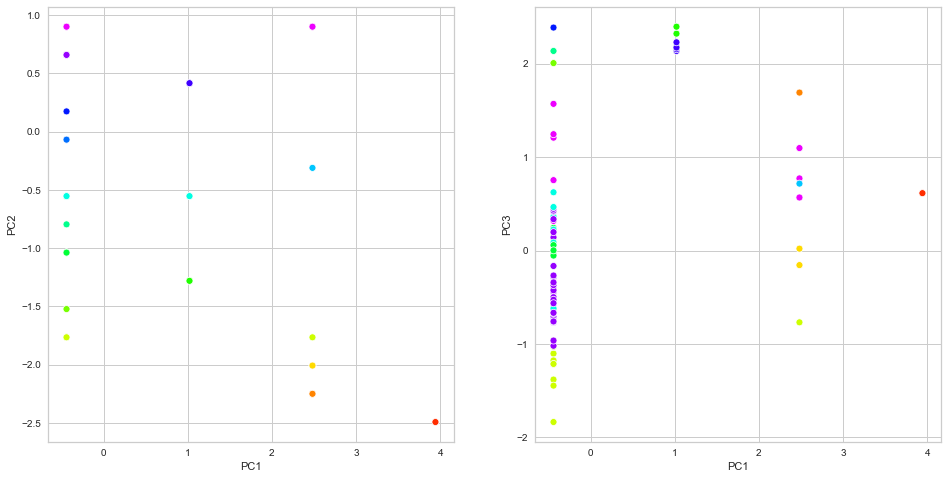

In [75]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=scaled_geo_df['DISTRICT'], 
                palette=sns.color_palette('gist_rainbow', n_colors=districts.shape[0]))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend('')
plt.subplot(1, 2, 2)
sns.scatterplot(x=X[:, 0], y=X[:, 2], hue=geo_df['DISTRICT'], 
                palette=sns.color_palette('gist_rainbow', n_colors=districts.shape[0]))
plt.xlabel('PC1')
plt.ylabel('PC3')

plt.legend('')

Next i will use Hierchical Clustering with complete linkage.

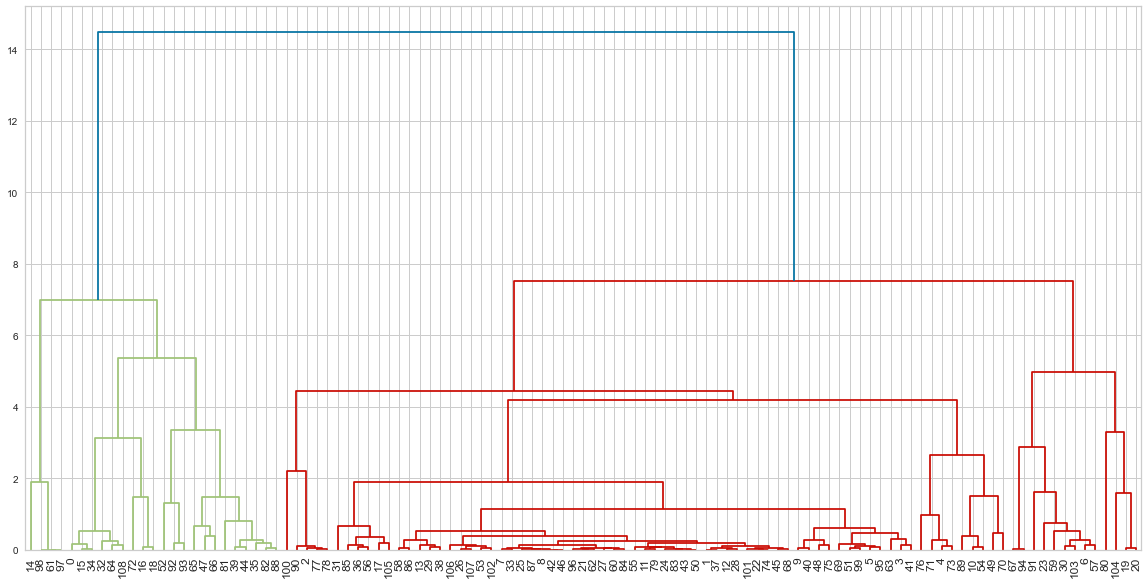

In [76]:
from scipy.cluster.hierarchy import dendrogram, linkage

cluster_model_complete = linkage(geo_df, 'complete')

plt.figure(figsize=(20, 10))
_ = dendrogram(cluster_model_complete, orientation='top', leaf_font_size=12)

Based on the above dendrogram and the previous elbow and silhouete methods i will choose 7 clusters for the data. I will extract the clusters and assign them to the dataset along with the names.

In [77]:
from scipy.cluster.hierarchy import fcluster

hc_labels = fcluster(cluster_model_complete, 7, criterion='maxclust')
hc_labels

array([2, 5, 4, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 1, 2, 2, 5, 2, 7, 7, 5,
       5, 6, 5, 5, 5, 5, 5, 5, 6, 5, 2, 5, 2, 3, 5, 5, 5, 3, 5, 5, 5, 5,
       3, 5, 5, 3, 5, 5, 5, 5, 3, 5, 5, 5, 5, 6, 5, 6, 5, 1, 5, 5, 2, 3,
       3, 6, 5, 5, 5, 5, 2, 5, 5, 5, 5, 4, 4, 5, 7, 3, 3, 5, 5, 5, 5, 5,
       3, 5, 4, 6, 3, 3, 6, 5, 5, 1, 1, 5, 4, 5, 5, 6, 7, 5, 5, 5, 2],
      dtype=int32)

In [78]:
geo_df['Cluster'] = hc_labels
geo_df['Name'] = names
geo_df.head(5)

,REGION,DISTRICT,Lat West,Long North,Cluster,Name
0,0,6,3.875,56.62,2,Aberfeldy
1,0,13,3.22,57.46,5,Aberlour
2,1,12,6.08,55.64,4,Ardberg
3,0,13,2.67,57.32,5,Ardmore
4,2,14,4.39,55.91,5,Auchentoshan


Based on geographic informations the clusters are 7 while on just the whiskey characteristics were 2. This can be explained by the fact the whiskies came from a lot of diferent points while shared a lot of common characteristics.